In [121]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, DBSCAN

from sklearn.metrics.cluster import silhouette_score, adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score

In [122]:
penguins = sns.load_dataset("penguins")
penguins = penguins.sample(frac=1).reset_index(drop=True)

In [123]:
# 펭귄 bill_lenght_mm, bill_depth_mm, filpper_length_mm, body_mass_g 를 가지고
# 스케일링 후, k-means, mean shift, dbscan으로 군집하자
# k-means는 최적의 k를 찾을 수 있도록 elbow graph 그리고, 실루엣 점수로 그래프 그린 후
# k를 확정하여 학습하자
# 각 모델의 ari, nmi, 실루엣 점수를 출력하자.

In [124]:
penguins.dropna(inplace=True)
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,36.2,16.1,187.0,3550.0,Female
1,Gentoo,Biscoe,50.8,17.3,228.0,5600.0,Male
2,Gentoo,Biscoe,55.9,17.0,228.0,5600.0,Male
3,Adelie,Dream,41.1,17.5,190.0,3900.0,Male
4,Chinstrap,Dream,51.3,18.2,197.0,3750.0,Male
...,...,...,...,...,...,...,...
339,Adelie,Biscoe,41.3,21.1,195.0,4400.0,Male
340,Adelie,Dream,37.3,17.8,191.0,3350.0,Female
341,Adelie,Torgersen,34.6,21.1,198.0,4400.0,Male
342,Gentoo,Biscoe,50.8,15.7,226.0,5200.0,Male


In [125]:
x = penguins[["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]]

In [126]:
sclaer = StandardScaler()

In [127]:
x_sclaer = sclaer.fit_transform(x)

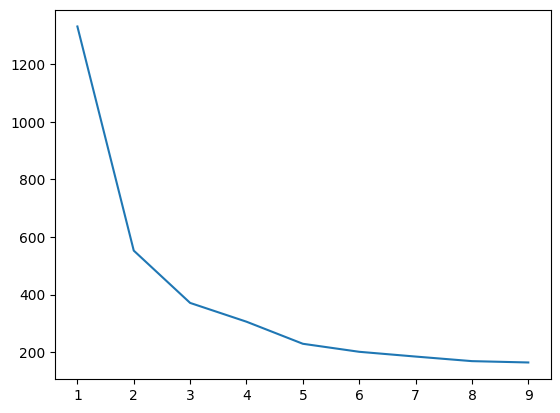

In [128]:
inertia_list = list()

for i in range(1, 10):
    model = KMeans(n_clusters=i, n_init="auto", random_state=1)
    model.fit(x_sclaer)
    inertia_list.append(model.inertia_)

# x: cluster 갯수
# y : inertia 값
#  elbow graph : 적절한 k의 값을 찾기 위해 k를 변화 시켜보자.
#  -> inertia 의 변화가 급격한 부분이 적절한 k이다!!
# 중심까지의 변화가 어떻게 되는데?
plt.plot(range(1, 10), inertia_list)

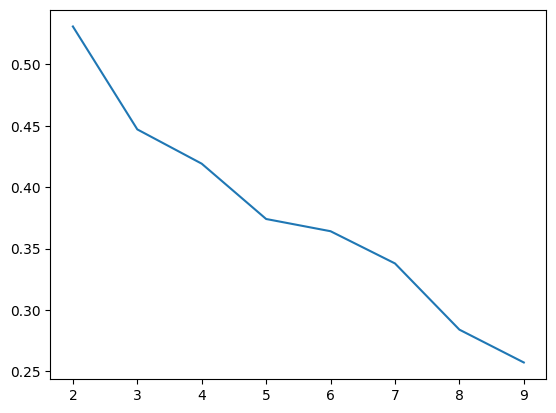

In [129]:
silhouette_score_list = list()

for i in range(2, 10):
    model = KMeans(n_clusters=i, n_init="auto", random_state=1)
    model.fit(x_sclaer)
    silhouette_score_list.append(silhouette_score(x_sclaer, model.labels_))


plt.plot(range(2, 10), silhouette_score_list)

In [159]:
from sklearn.preprocessing import LabelEncoder

In [174]:
models = pd.DataFrame(x_sclaer, columns=["x01", "x02", "x03", "x04"])
models["species"] = LabelEncoder().fit_transform(penguins["species"])
models

,x01,x02,x03,x04,species
0,-1.427134,-0.541564,-0.998018,-0.817229,0
1,1.246638,0.068726,1.931662,1.732503,2
2,2.180627,-0.083846,1.931662,1.732503,2
3,-0.529772,0.170442,-0.783651,-0.381909,0
4,1.338206,0.526444,-0.283462,-0.568475,1
...,...,...,...,...,...
328,-0.493145,2.001313,-0.426373,0.239977,0
329,-1.225685,0.323014,-0.712196,-1.065984,0
330,-1.720150,2.001313,-0.212006,0.239977,0
331,1.246638,-0.744994,1.788750,1.234995,2


In [175]:
# k-means
model01 = KMeans(n_clusters=3, n_init="auto", random_state=1)
model01.fit(x_sclaer)
models["k-means"] = model01.predict(x_sclaer)

In [176]:
# mean shift
# estimate_bandwidth : 최적의 대여폭을 찾아줌
bandwidth = round(estimate_bandwidth(x_sclaer), 3)
model02 = MeanShift(bandwidth=bandwidth)
models["mean-shift"] = model02.fit(x_sclaer).labels_

In [177]:
# DBSCAN
model03 = DBSCAN(eps=0.25)
models["dbscan"] = model03.fit_predict(x_sclaer)

In [184]:
metrics_df = pd.DataFrame(models.iloc[:, 5:].columns, columns=["model"])
metrics_df

,model
0,k-means
1,mean-shift
2,dbscan


In [188]:
ari = list()
nmi = list()
silhouette = list()

for predict in models.iloc[:, 5:]:
    ari.append(adjusted_rand_score(models["species"], models[predict]))
    nmi.append(normalized_mutual_info_score(models["species"], models[predict]))
    try:
        silhouette.append(silhouette_score(models[["x01", "x02", "x03", "x04"]], models[predict]))
    except:
        # 실루엣 계수는 2개 이상으로 클러스터링 되야 값이 나온다 (meanshift가 1개로 군집되어 있어서 error)
        silhouette.append(0)

In [189]:
metrics_df["ari"] = ari                     # 정답에 얼마나 가까운지
metrics_df["nmi"] = nmi                     # 상관관계
metrics_df["silhouette"] = silhouette       # 군집이 얼마나 잘되어 있는지

In [190]:
metrics_df

,model,ari,nmi,silhouette
0,k-means,0.805914,0.794144,0.447011
1,mean-shift,0.639203,0.700494,0.520745
2,dbscan,0.000000,0.000000,0.000000
